# Simulación de curvas periódicas

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import numpy as np
import pandas as pd
from scipy import signal

import torch

import matplotlib.pyplot as plt

from torch.utils.data import Dataset

## Generación de curvas períodicas

### Visualización de curvas

In [2]:
def plot_periodic(mjd, mag, P, ax):
    ax[0].plot(mjd, mag, '.')
    ax[0].set_xlabel('Tiempo')
    ax[1].plot(np.mod(mjd, P)/P, mag, '.')
    ax[1].set_xlabel('Fase');

### Random MJD's

In [3]:
def random_dates(start='1970-01-01', end='2022-09-01', N=100):
    "Create N mjd within range."
    start_seconds = pd.to_datetime(start).value//10**9
    end_seconds = pd.to_datetime(end).value//10**9

    rand_dates = pd.to_datetime(np.random.randint(start_seconds, end_seconds, N), unit='s')
    rand_mjd = rand_dates.to_julian_date() - 2400000.5
    return rand_mjd.values.round(3) 

### Señal cuadrada

In [4]:
def random_periodic_square_signal(period, seq_len=100, s_noise=0.2, irregular=True):
    """Genera una curva aleatoria de señales cuadradas.

    Parameters
    ----------
    seq_len : int
        Número int que define la cantidad de períodos a generar.
    s_noise : float
        float que fija la cantidad de ruido a agregar.

    Returns
    -------
    tuple
        tuple con los tiempos y magnitudes de la curva.            
    """    
    mjd = random_dates(N=seq_len)
    if irregular:
        mjd += np.random.randn(seq_len)*0.1
    mjd = np.sort(mjd)
    mag = signal.square(2 * np.pi * mjd/period) 
    mag += np.random.randn(seq_len)*s_noise
    return mjd, mag

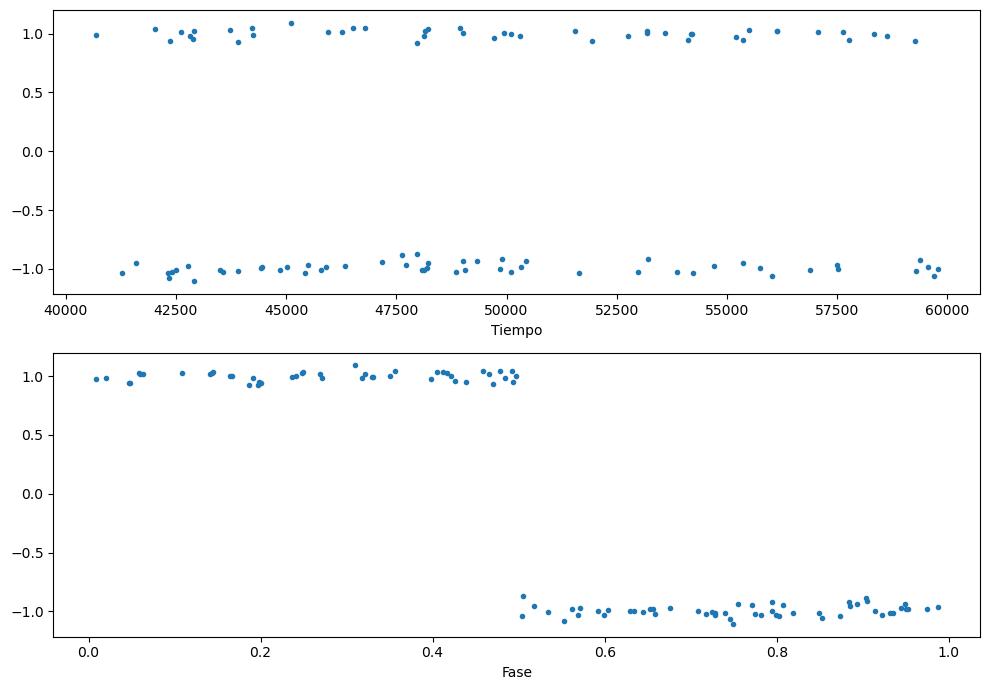

In [6]:
P = 1.234
mjd, mag = random_periodic_square_signal(P, s_noise=0.05)

fig, ax = plt.subplots(2, figsize=(10,7), tight_layout=True)
plot_periodic(mjd, mag, P, ax)

## Señal diente de sierra

In [7]:
def random_periodic_sawtooth_signal(period, seq_len=100, s_noise=0.2, irregular=True):
    """Genera una curva aleatoria de diente de sierra.

    Parameters
    ----------
    seq_len : int
        Número int que define la cantidad de períodos a generar.
    s_noise : float
        float que fija la cantidad de ruido a agregar.

    Returns
    -------
    tuple
        tuple con los tiempos y magnitudes de la curva.            
    """    
    mjd = random_dates(N=seq_len)
    if irregular:
        mjd += np.random.randn(seq_len)*0.1
    mjd = np.sort(mjd)
    mag = signal.sawtooth(2 * np.pi * mjd/period) 
    mag += np.random.randn(seq_len)*s_noise
    return mjd, mag

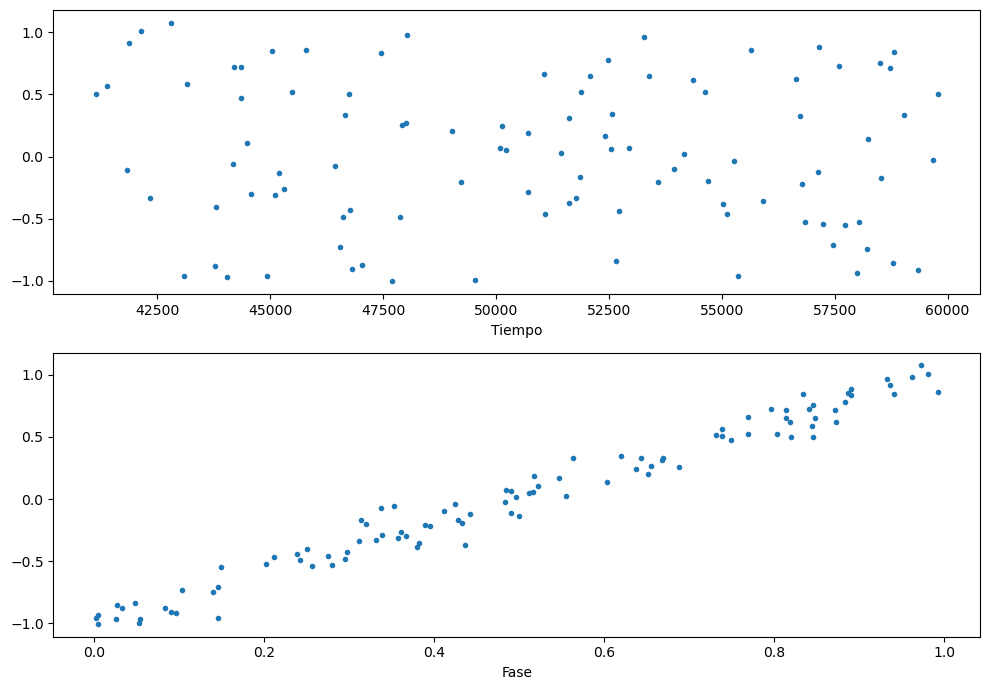

In [9]:
P = 1.234
mjd, mag = random_periodic_sawtooth_signal(P, s_noise=0.1)

fig, ax = plt.subplots(2, figsize=(10,7), tight_layout=True)
plot_periodic(mjd, mag, P, ax)

## Suma de sinusoides

In [10]:
def random_periodic_sin_mix(period, seq_len=100, s_noise=0.2, irregular=True):
    """Genera una curva aleatoria de suma de sinusoides.

    Parameters
    ----------
    seq_len : int
        Número int que define la cantidad de períodos a generar.
    s_noise : float
        float que fija la cantidad de ruido a agregar.

    Returns
    -------
    tuple
        tuple con los tiempos y magnitudes de la curva.            
    """
    mjd = random_dates(N=seq_len)
    if irregular:
        mjd += np.random.randn(seq_len)*0.1
    mjd = np.sort(mjd)
    mag = np.sin(2.0*np.pi*mjd/period) + 0.5*np.sin(2.0*np.pi*2*mjd/period)  + 0.25*np.sin(2.0*np.pi*3*mjd/period)
    mag += np.random.randn(seq_len)*s_noise
    return mjd, mag

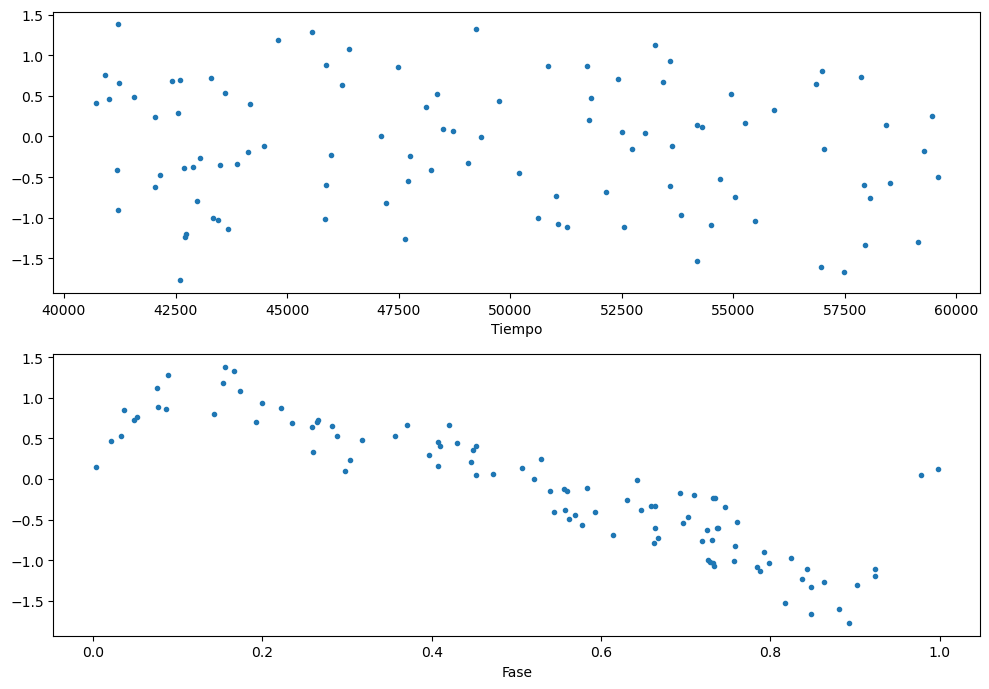

In [11]:
P = 1.234
mjd, mag = random_periodic_sin_mix(P)

fig, ax = plt.subplots(2, figsize=(10,7), tight_layout=True)
plot_periodic(mjd, mag, P, ax)

## Adaptación a dataset de Pytorch

### Dataset class

In [12]:
class lc_dataset(Dataset):
    def __init__(self, seed=42):
        # Set seed
        self.seed = seed
        np.random.seed(self.seed)

        # Generators
        self.curve_generators = {'square': random_periodic_square_signal,
                                'sawtooth': random_periodic_sawtooth_signal,
                                'sinmix': random_periodic_sin_mix}

        # Curve data
        self.period_list = []
        self.mjd_list = []
        self.mag_list = []
        self.labels = []

    def generate_periods(self, N, min_period, max_period):
        """Genera una lista de períodos random.

        Parameters
        ----------
        N : int
            Número int que define la cantidad de períodos a generar.
        min_period : float
            float que define el mínimo valor posible a generar.
        max_period : float
            float que define el máximo valor posible a generar.

        Returns
        -------
        np.ndarray
            np.ndarray con el arreglo de períodos generados.            
        """
        random_period_list = []
        for idx in range(N):
            random_period = np.random.uniform(min_period, max_period)
            random_period_list.append(random_period)
        return random_period_list
        
    def add_curves(self, curve_type, N, seq_len, min_period, max_period, label):
        """Añade N curvas de un determinado tipo al dataset.

        Parameters
        ----------
        curve_type : str
            str que define el tipo de curvas a generar.
        N : int
            Número int que define la cantidad de períodos a generar.            
        min_period : float
            float que define el mínimo valor posible a generar.
        max_period : float
            float que define el máximo valor posible a generar.
        label : int
            int que define el label que tendrán las curvas generadas.            
        """
        period_list = self.generate_periods(N, min_period, max_period)
        self.period_list += period_list
        for period in period_list:
            mjd, mag = self.curve_generators[curve_type](period, seq_len=seq_len)
            self.mjd_list.append(mjd)
            self.mag_list.append(mag)
            self.labels.append(label)

    def to_df(self):
        """Transforma los datos generados en un Pandas DataFrame.

        Returns
        -------
        pd.DataFrame
            pd.DataFrame con los datos generados.            
        """        
        dataset_df = pd.DataFrame({'mjd':self.mjd_list,
                                    'mag':self.mag_list,
                                    'period':self.period_list,
                                    'label':self.labels})
        return dataset_df

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        curve_dict = {'mjd':torch.tensor(self.mjd_list[idx]),
                    'mag':torch.tensor(self.mag_list[idx]),
                    'period':torch.tensor(self.period_list[idx]),
                    'label':torch.tensor(self.labels[idx])}
        return curve_dict

### Prueba

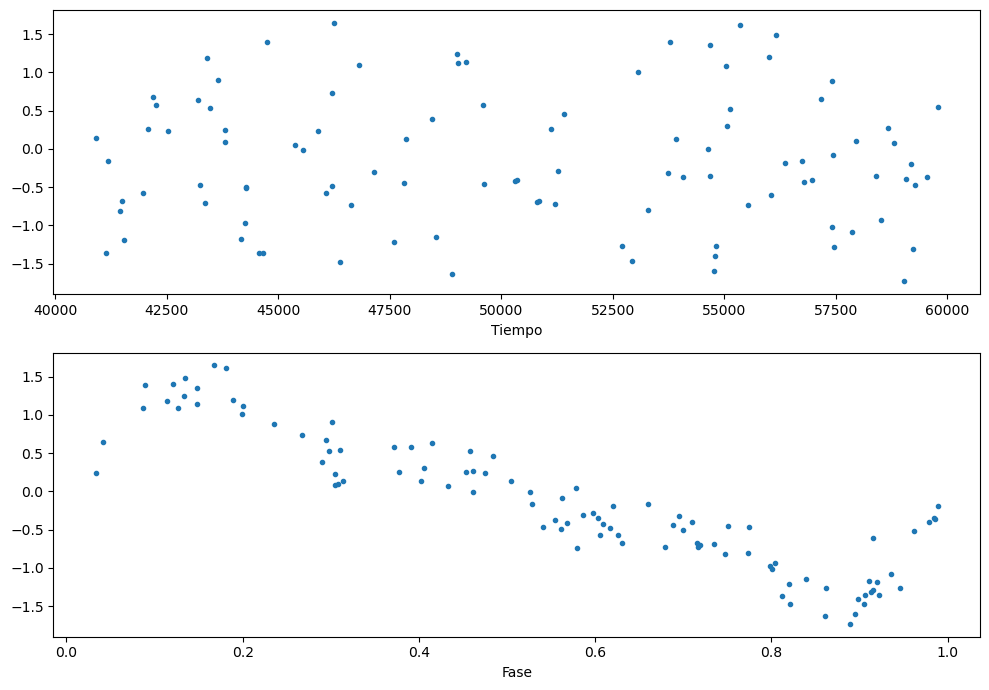

In [14]:
dataset = lc_dataset()
dataset.add_curves('sinmix', 100, 100, 0.2, 2, 0)

fig, ax = plt.subplots(2, figsize=(10,7), tight_layout=True)
obj_id = 40
plot_periodic(*dataset.to_df().loc[obj_id].values[:-1], ax)

In [15]:
dataset.add_curves('sawtooth', 100, 100,5, 10, 1)
dataset.to_df()

,mjd,mag,period,label
0,"[40612.7876822335, 40720.11531026685, 40932.67...","[-0.20068288220832498, 0.043835752023271946, 0...",0.874172,0
1,"[41151.33667413885, 41191.343967297755, 41249....","[-0.5047309374426222, -0.39351590789948315, 1....",1.911286,0
2,"[40700.72850227826, 40879.7873101258, 41193.47...","[0.3243465512224265, 0.29602902221245353, 0.47...",1.517589,0
3,"[40753.45204734205, 40839.541297799566, 41217....","[-1.4713297393015443, 1.1070672134434352, 0.87...",1.277585,0
4,"[40832.64389285898, 40946.7462570432, 41362.27...","[-0.20707202738599503, -1.349845772268231, 0.3...",0.480834,0
...,...,...,...,...
195,"[40620.09857522439, 40704.95081093557, 40721.3...","[0.19810192622044304, -0.7492554407634052, -0....",7.371238,1
196,"[40667.68046754504, 41429.85830903687, 41726.0...","[-0.2829443060065291, 0.7719035098706017, 0.60...",9.855546,1
197,"[40680.1333994992, 40776.254094875214, 40859.3...","[0.3375619011973389, -0.5156949172485872, 1.16...",7.058111,1
198,"[40642.50611262407, 40741.70888311464, 40806.9...","[1.1096885959133131, -0.710243556626117, 0.741...",6.090640,1
